In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvelo as scv
import matplotlib.pyplot as plt
from spvelo import *
import gseapy as gp
from gseapy import Msigdb
import random

setup_seed(0)
msig = Msigdb()

[rank: 0] Global seed set to 0


In [2]:
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/filter_uncertainty.h5ad')
adata = adata[adata.obs.batch=='9']
high_cutoff = np.percentile(adata.obs['uncertainty'], 50)
low_cutoff = np.percentile(adata.obs['uncertainty'], 50)
high_cells = adata[adata.obs['uncertainty'] >= high_cutoff]
low_cells = adata[adata.obs['uncertainty'] <= low_cutoff]

In [3]:
adata.obs['uncertainty_group'] = '0'
adata.obs.loc[adata.obs['uncertainty'] >= high_cutoff, 'uncertainty_group'] = 'high'
adata.obs.loc[adata.obs['uncertainty'] <= low_cutoff, 'uncertainty_group'] = 'low'

In [4]:
# DE test between high vs low
sc.tl.rank_genes_groups(adata, groupby='uncertainty_group', method='wilcoxon', key_added="wilcoxon")

# Get ranked gene list for high-uncertainty cells
scores = adata.uns['wilcoxon']['scores']['high']
gene_names = adata.uns['wilcoxon']['names']['high']
rnk_high = pd.DataFrame({'gene': gene_names, 'score': scores}).sort_values("score", ascending=False)
high_genes = rnk_high[rnk_high['score']>0]['gene'].tolist()

In [5]:
gmt = msig.get_gmt(category='c2.all', dbver="2023.2.Hs")
pre_res = gp.prerank(rnk=rnk_high,
                     gene_sets=gmt,
                     threads=1,
                     min_size=1,
                     max_size=10000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None,
                     seed=0,
                     verbose=True,
                    )

2025-05-04 14:55:36,632 [INFO] Parsing data files for GSEA.............................
2025-05-04 14:55:36,697 [INFO] 3899 gene_sets have been filtered out when max_size=10000 and min_size=1
2025-05-04 14:55:36,699 [INFO] 3334 gene_sets used for further statistical testing.....
2025-05-04 14:55:36,700 [INFO] Start to run GSEA...Might take a while..................
2025-05-04 14:55:40,246 [INFO] Congratulations. GSEApy runs successfully................



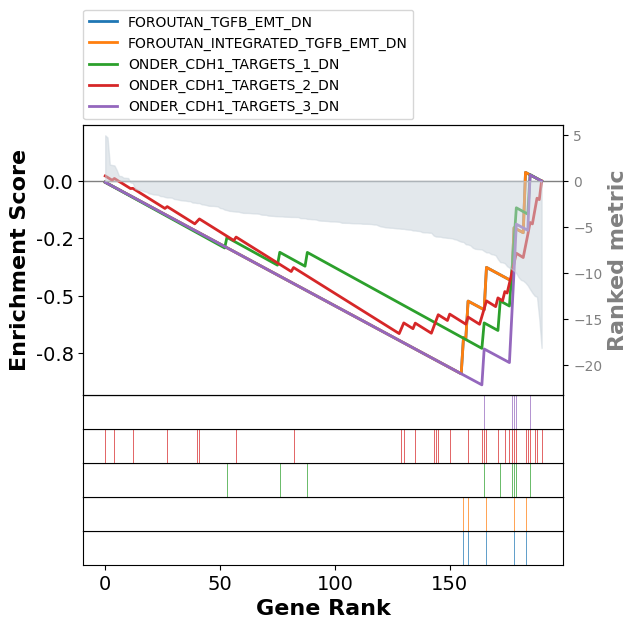

In [6]:
related_terms = ['FOROUTAN_TGFB_EMT_DN', 'FOROUTAN_INTEGRATED_TGFB_EMT_DN', 'ONDER_CDH1_TARGETS_1_DN', 
                 'ONDER_CDH1_TARGETS_2_DN', 'ONDER_CDH1_TARGETS_3_DN']
axs = pre_res.plot(terms=related_terms, show_ranking=True)